# Part 1: Introduction

In this notebook, we determine on extracting key features of galaxy based on the question tree diagram from Hart et al. [(2016)](https://mnras.oxfordjournals.org/content/461/4/3663). The final goal is to train and compare the accuracy of classification models learnt from our extracted features vs from the morphology measurement Table 1 (Hart et al. [2016](https://mnras.oxfordjournals.org/content/461/4/3663)). 

# Part 2: Set up Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import os
from pathlib import Path
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np

In [235]:
import pandas as pd

In [139]:
from skimage.morphology import (erosion, dilation, opening, closing, skeletonize, convex_hull_image)
from skimage.morphology import disk

# Part 3: Set up Data

### Path to images

In [2]:
path_IMG = Path('/kaggle/input/galaxy-zoo-2-images/images_gz2/images')

In [3]:
path_jpg = list(path_IMG.glob(r"*.jpg"))

In [4]:
path_jpg_series = pd.Series(path_jpg,name="JPG").astype(str)

In [5]:
print(path_jpg_series)

0         /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
1         /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
2         /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
3         /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
4         /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
                                ...                        
243429    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
243430    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
243431    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
243432    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
243433    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
Name: JPG, Length: 243434, dtype: object


### Visualization

Note: use cv2 or plt will give different color visualization (cv2: BGR, plt: RGB)

Text(0.5, 1.0, '64601.jpg')

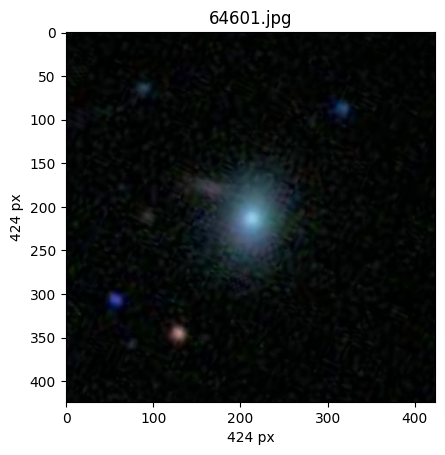

In [6]:
# Read an image
img = cv2.imread(path_jpg_series[0])
name_img = path_jpg_series[0].replace('/kaggle/input/galaxy-zoo-2-images/images_gz2/images/', '')

# Plot
plt.imshow(img)
plt.xlabel("{} px".format(img.shape[1]))
plt.ylabel("{} px".format(img.shape[0]))
plt.title(name_img)

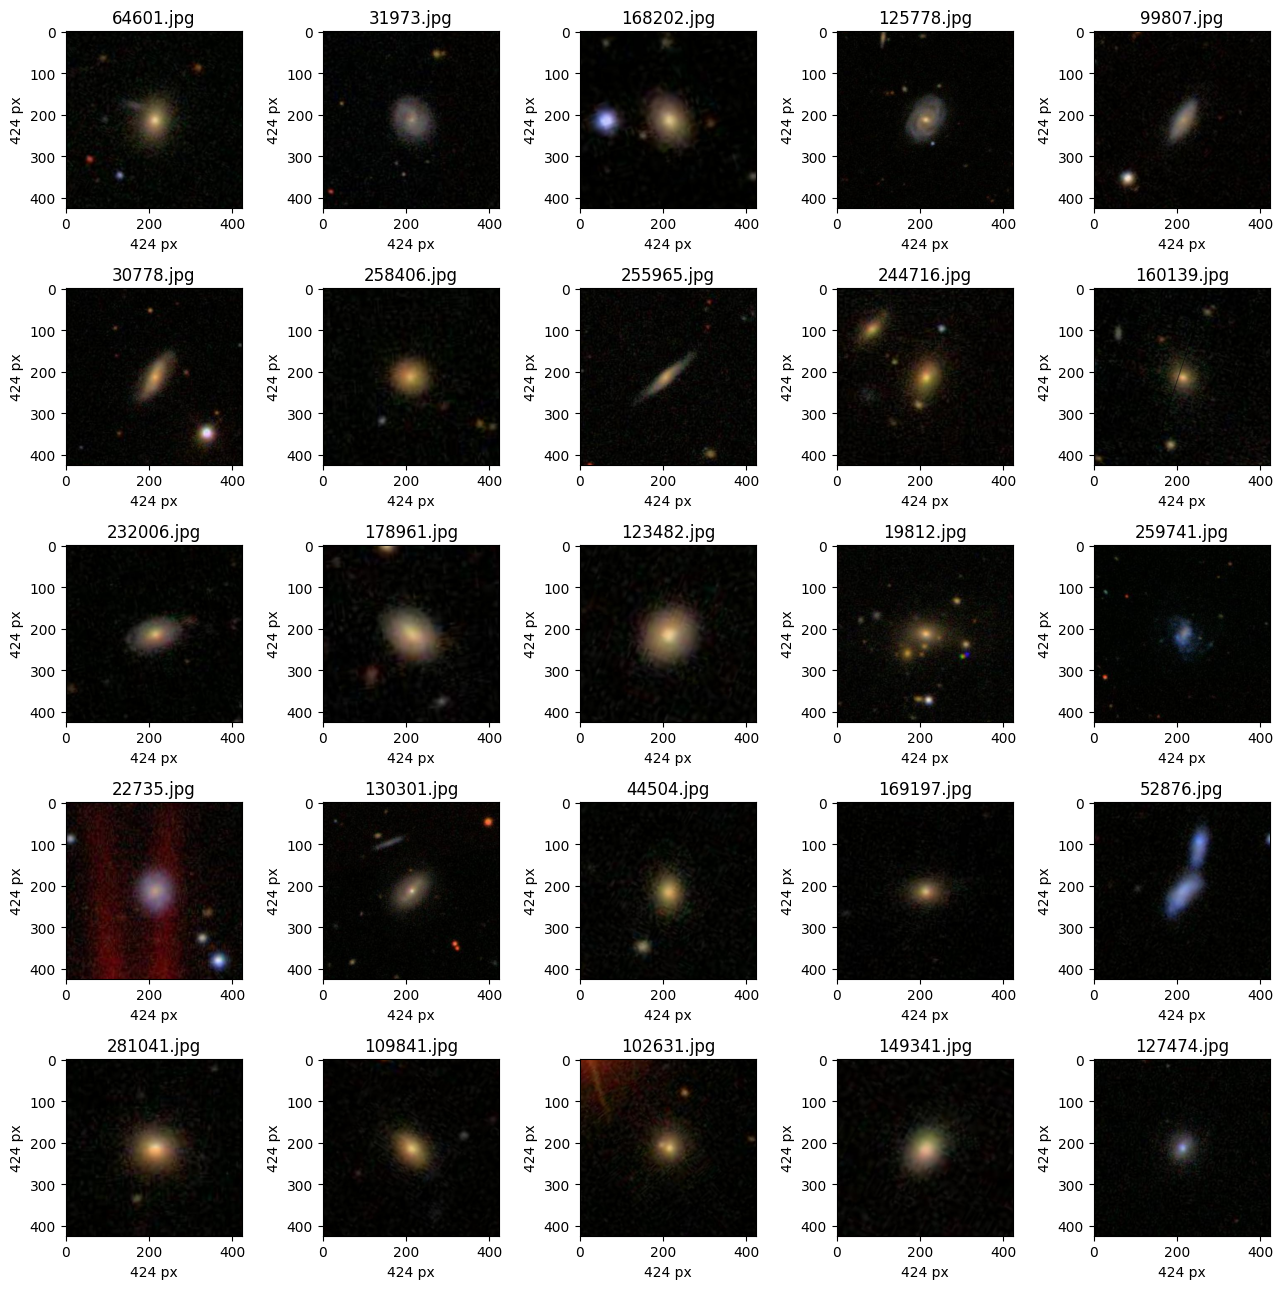

In [7]:
# Plot 25 galaxies
figure,axes = plt.subplots(nrows=5,ncols=5,figsize=(13,13))
for i,ax in enumerate(axes.flat):
    imgs = plt.imread(path_jpg_series[i])
    name_imgs = path_jpg_series[i].replace('/kaggle/input/galaxy-zoo-2-images/images_gz2/images/', '')
    ax.imshow(imgs)
    ax.set_xlabel("{} px".format(imgs.shape[1]))
    ax.set_ylabel("{} px".format(imgs.shape[0]))
    ax.set_title(name_imgs)
plt.tight_layout()
plt.show()

# Part 4: Feature Extraction

Based on the Question tree diagram in Hart et al. ([2016](https://mnras.oxfordjournals.org/content/461/4/3663)), the features should be:
- Simple descriptors: 
Area, Perimeter, Orientation, Eccentricity, Solidity, …
- Special features: 
Spiral arms, Bulge shape (for spiral), Lens, Rings, Merger, Irregular, ...
- Physical properties: 
Total surface brightness, Bulge light intensity, … 



## Mass cutout and resize images to only 1 channel

In [9]:
Transformated_IMG = []

for X_Img in path_jpg_series:
    IMG = cv2.imread(X_Img,0)
    IMG = IMG[120:300,110:310]
    R_IMG = cv2.resize(IMG,(28,28))
    Transformated_IMG.append(R_IMG)

In [234]:
np.shape(Transformated_IMG)

(243434, 28, 28)

## Inspection 

In [231]:
def ConvertColorSpaces(image, ColorSpace = "GRAY", display = 1):
  ImageTitleList = ["RGB", ColorSpace]

  if(ColorSpace.upper() == "HSV"):
    image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ChannelList = ["Chrominance Hue" , "Chrominance Saturation", "Luminance Value"]
  elif(ColorSpace.upper() == "YCRCB"):
    image_convert = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    ChannelList = ["Chrominance Red" , "Chrominance Blue", "Luminance Y"]
  elif(ColorSpace.upper() == "LAB"):
    image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    ChannelList = ["Chrominance a(Green To Red)" , "Chrominance b(Blue To Yellow)", "Luminance L"]
  else:
    image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  if(display):
    img_display = [image, image_convert, image_convert[:,:,0], image_convert[:,:,1], image_convert[:,:,2]]
    img_title = ImageTitleList + ChannelList
    if(len(image_convert.shape) == 3):
        figure,axes = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
        for i,ax in enumerate(axes.flat):
            ax.imshow(img_display[i], plt.cm.gray)
            ax.set_xlabel("{} px".format(imgs.shape[1]))
            ax.set_ylabel("{} px".format(imgs.shape[0]))
            ax.set_title(img_title[i])
        plt.tight_layout()
        plt.show()

    else:
        img_display = [image, image_convert]
        figure,axes = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
        for i,ax in enumerate(axes.flat):
            ax.imshow(img_display[i], plt.cm.gray)
            ax.set_xlabel("{} px".format(imgs.shape[1]))
            ax.set_ylabel("{} px".format(imgs.shape[0]))
            ax.set_title(ImageTitleList)
        plt.tight_layout()
        plt.show()

  return image_convert

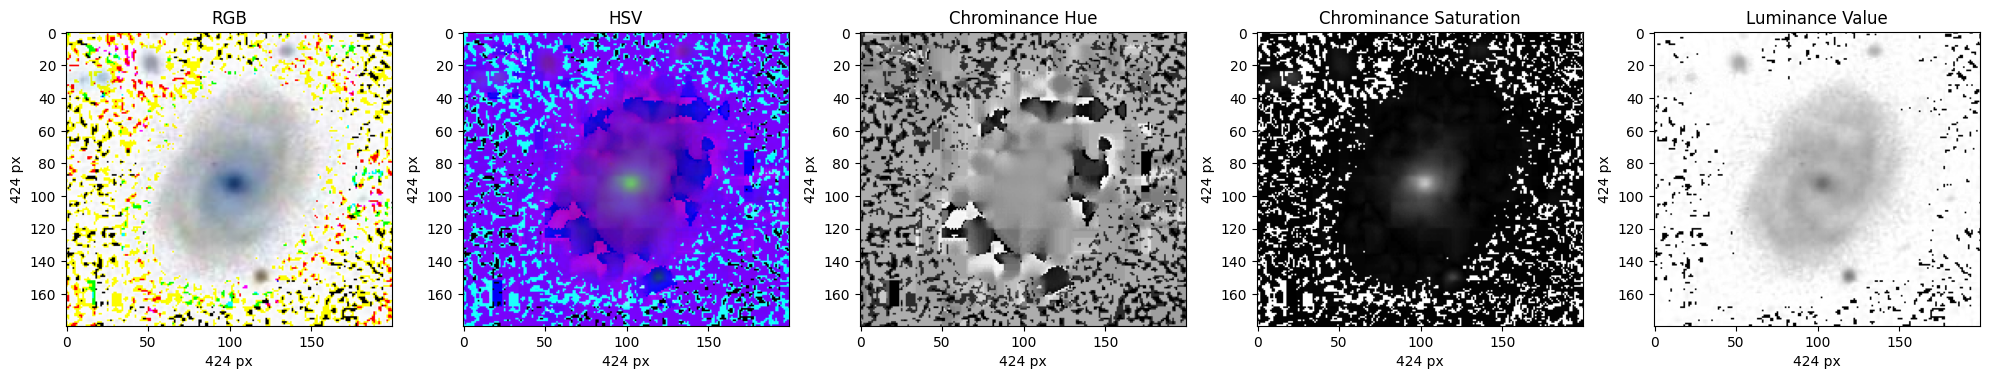

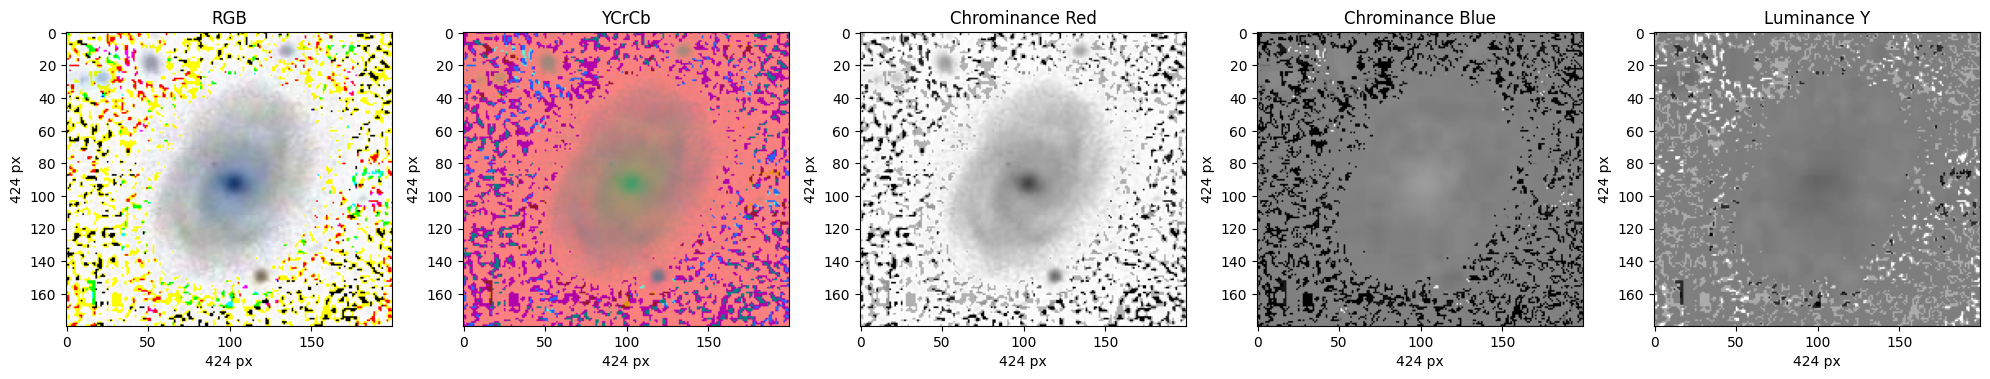

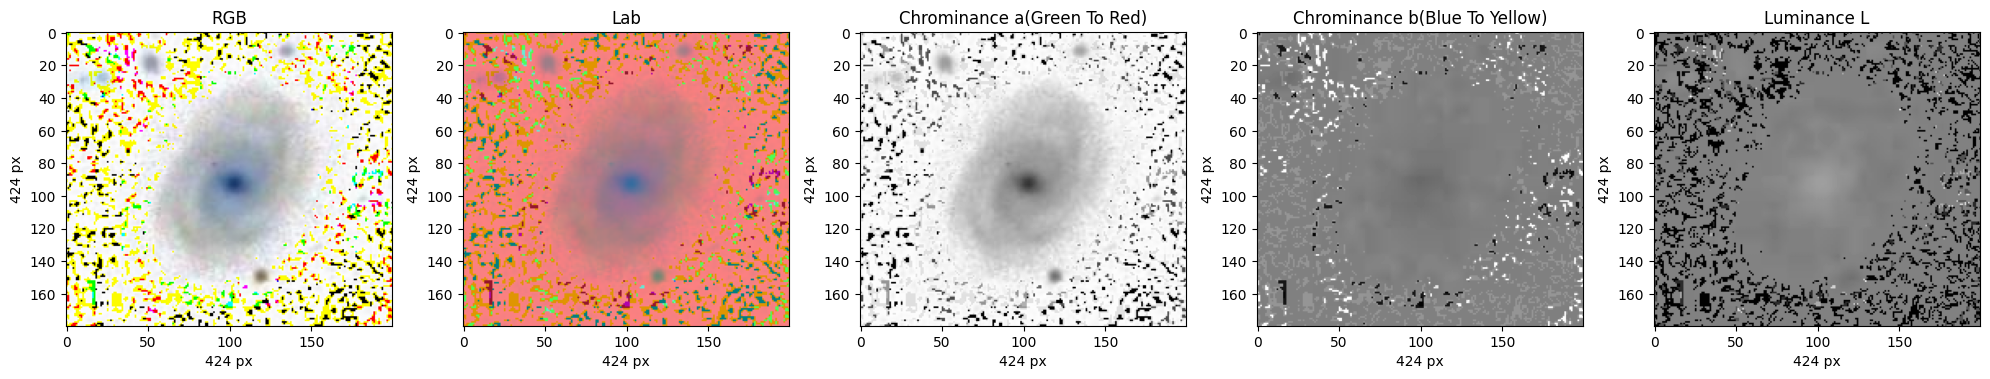

In [232]:
AnImage = plt.imread(path_jpg_series[3])
AnImage = AnImage[120:300,110:310]
AnImage = (AnImage*255).astype(np.uint8)
#image_gray = ConvertColorSpaces(AnImage, ColorSpace = "GRAY")
image_hsv = ConvertColorSpaces(AnImage, ColorSpace = "HSV")
image_ycrcb = ConvertColorSpaces(AnImage, ColorSpace = "YCrCb")
image_lab = ConvertColorSpaces(AnImage, ColorSpace = "Lab")

## Segmentation

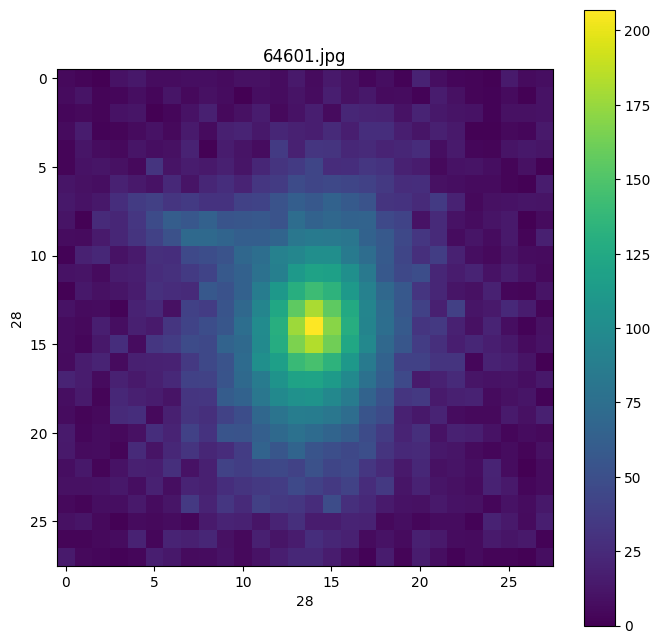

In [107]:
# Plot the first galaxy in the list 
index = 0
figure = plt.figure(figsize=(8,8))
plt.imshow(Transformated_IMG[index]) 
plt.xlabel(Transformated_IMG[index].shape[1])
plt.ylabel(Transformated_IMG[index].shape[0])
plt.title(path_jpg_series[index].replace('/kaggle/input/galaxy-zoo-2-images/images_gz2/images/', ''))
plt.colorbar()

In [76]:
img_ex = Transformated_IMG[0]

In [131]:
# Histogram
def plot_histogram(image):
    histr = cv2.calcHist([img_ex],[0],None,[256],[0,256]) 
    # show the plotting graph of an image 
    plt.plot(histr)
    plt.xlabel('Pixel values')
    plt.ylabel('No of pixels')
    plt.show() 

### Apply morphology for noise removal 

In [158]:
def show_morphology(image, size = 2): 
    kernel = disk(abs(size))
    noise_remove = closing(image, kernel)
    
    plt.figure(figsize=(10,10))
    plt.subplot(231)
    plt.imshow(image)
    plt.title('original')
    plt.subplot(232)
    plt.imshow(erosion(image, kernel))
    plt.title('erosion')
    plt.subplot(233)
    plt.imshow(dilation(image, kernel))
    plt.title('dilation')
    plt.subplot(234)
    plt.imshow(opening(image, kernel))
    plt.title('opening')
    plt.subplot(235)
    plt.imshow(closing(image, kernel))
    plt.title('closing')
    plt.show()
    
    return noise_remove

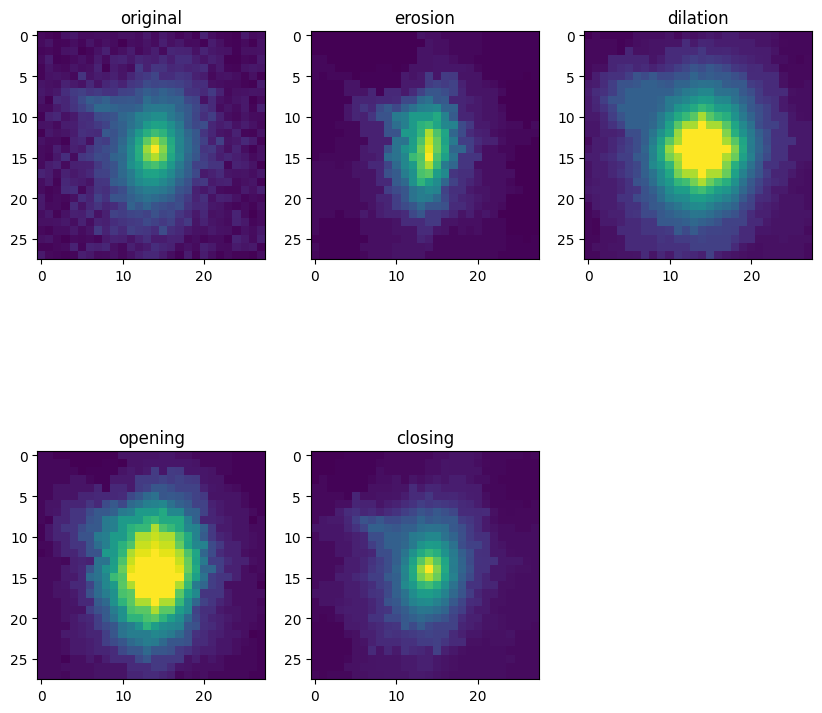

In [159]:
img_clean = show_morphology(img_ex, size = 3)

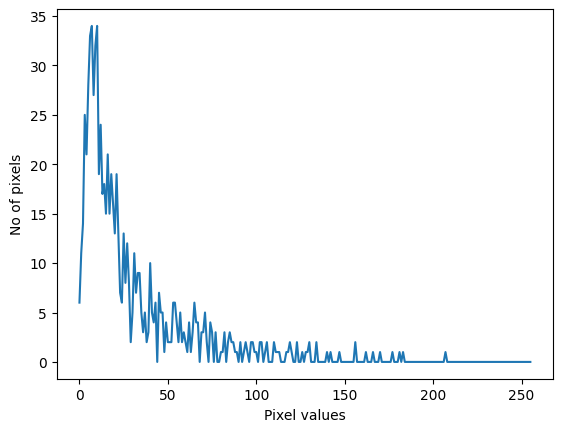

In [155]:
plot_histogram(img_ex)

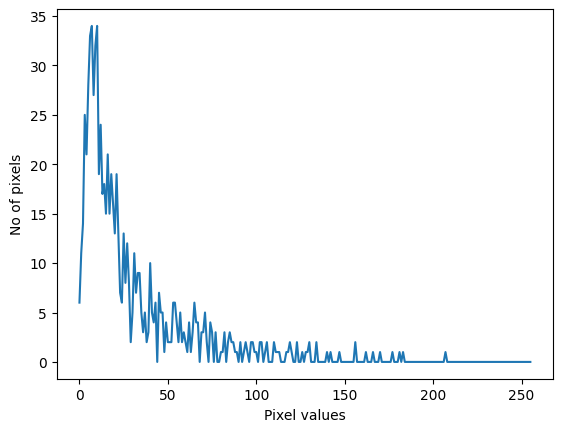

In [161]:
plot_histogram(img_clean)

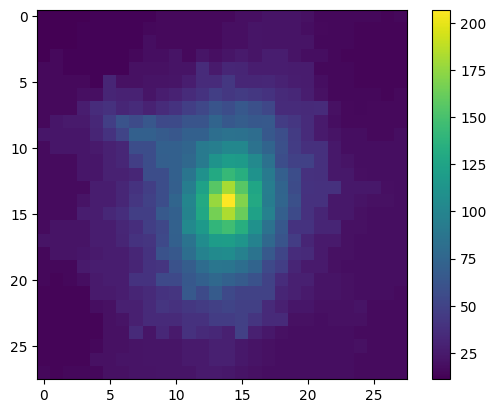

In [166]:
plt.imshow(img_clean)
plt.colorbar()

In [ ]:
# Example of morphology of a spiral non-edge-on galaxy
_ = show_morphology(Transformated_IMG[3], size = 3)

In [ ]:
# Example of morphology of merging galaxy
_ = show_morphology(Transformated_IMG[13])

In [ ]:
_= show_morphology(Transformated_IMG[15])

## Simplify galaxy shape for Simple Descriptors

### Demo with 1 example

In [178]:
from skimage.measure import label, regionprops, regionprops_table
import math

In [225]:
def galaxy_descriptor(image, threshold = 50, plot=False): 
    # Binarize the image
    _, thresh = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    # Invert the image
    thresh1 = cv2.bitwise_not(thresh)

    # Region property
    label_img = label(thresh)
    regions = regionprops(label_img)
    
    props = regions[0]
    
    # Area: number of pixels of the region scaled by pixel-area
    Area = int(props.area)
    # Perimeter: approximates the contour as a line through the centers of border pixels using a 4-connectivity
    Perimeter = int(props.perimeter)
    # Orientation
    Orientation = int(props.orientation)
    # Eccentricity
    Eccentricity = props.eccentricity
    # Solidity: Ratio of pixels in the region to pixels of the convex hull image.
    Solidity = props.solidity
    
    info = [Area, Perimeter, Orientation, Eccentricity, Solidity]

    # Illustrate the region
    if plot == True: 
        plt.imshow(thresh, cmap='gray')
        plt.title('Binarize image')
        fig, ax = plt.subplots()
        ax.imshow(image, cmap=plt.cm.gray)

        for props in regions:
            y0, x0 = props.centroid
            orientation = props.orientation
            x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
            y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
            x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
            y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

            ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
            ax.plot(x0, y0, '.g', markersize=15)

            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            ax.plot(bx, by, '-b', linewidth=2.5)

        plt.show()
    
    return thresh, info

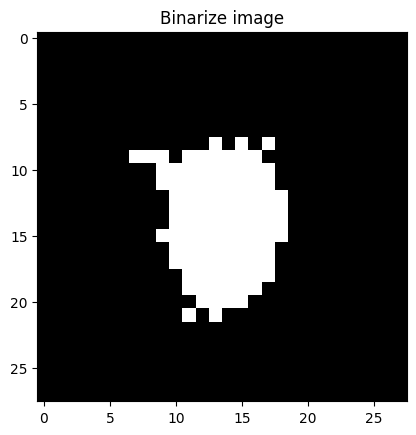

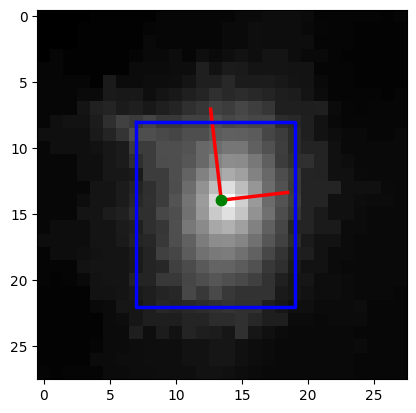

In [227]:
img_bi, info = galaxy_descriptor(img_clean, threshold = 65, plot=True)

In [228]:
info

[102, 37, 0, 0.6841466926899771, 0.8095238095238095]

### Mass extraction

In [274]:
def process_images(image_list, path_jpg_series, size_closing = 3, threshold = 65):
    galaxy_info = []
    for idx, image in enumerate(image_list):
        # Filename
        filename = path_jpg_series[idx].replace('/kaggle/input/galaxy-zoo-2-images/images_gz2/images/', '')
        filename = filename.replace('.jpg','')
        
        # Remove noise
        kernel = disk(abs(size_closing))
        clean_image = closing(image, kernel)
        
        # Descriptor
        _, info = galaxy_descriptor(clean_image, threshold = threshold, plot=False)
        
        # Save filename and descriptors
        Feature = {}
        Feature["FileName"] = str(filename)
        Feature["Area"] = str(info[0]) 
        Feature["Perimeter"] = str(info[1])
        Feature["Orientation"] = str(info[2])
        Feature["Eccentricity"] = str(info[3])
        Feature["Solidity"] = str(info[4])
        
        galaxy_info.append(Feature)
        
    df = pd.DataFrame(galaxy_info)
    
    return df

In [275]:
galaxy_df = process_images(Transformated_IMG, path_jpg_series)

In [276]:
galaxy_df

FileName Area Perimeter Orientation         Eccentricity  \
0         64601  102        37           0   0.6841466926899771   
1         31973   95        36           0   0.7010880648048295   
2        168202  120        41           0    0.682538394857283   
3        125778    2         0           0                  1.0   
4         99807   71        33           0   0.9149714344835805   
...         ...  ...       ...         ...                  ...   
243429   108550   91        34           0   0.7892861908847417   
243430   230486  122        42           0   0.7808357663008213   
243431    70594  113        43           1  0.44839783547860124   
243432   191748   23        16           0  0.49563171451506804   
243433   175178    1         0           0                    0   

                  Solidity  
0       0.8095238095238095  
1       0.9223300970873787  
2       0.9302325581395349  
3                      1.0  
4        0.922077922077922  
...                    ...  
243429  0.9285714285714286  
243430  0.9037037037037037  
243431   0.837037037037037  
243432  0.8214285714285714  
243433                 1.0  

[243434 rows x 6 columns]

In [278]:
# Save dataframe as csv
galaxy_df.to_csv('galaxy_info.csv', index=False)

## Special feature extraction

Spiral arms, Bulge shape (for spiral), Lens, Rings, Merger, Irregular, ...

## Physical properties

Total surface brightness, Bulge light intensity, …

### Download file csv to computer

In [281]:
import os
os.chdir(r'/kaggle/working')

In [282]:
from IPython.display import FileLink
FileLink(r'galaxy_info.csv')

/kaggle/working/galaxy_info.csv

# Part 5: Conclusion

## References:

https://academic.oup.com/mnras/article/435/4/2835/1022913

https://mnras.oxfordjournals.org/content/461/4/3663

https://www.kaggle.com/datasets/jaimetrickz/galaxy-zoo-2-images

https://www.kaggle.com/code/brsdincer/galaxies-segmentation-autoencoder-process/notebook